<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline, </h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [2]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib qt')   
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.base.rois import register_ROIs
from caiman.base.traces import trace
import os
import cv2
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import matplotlib.pyplot as plt


try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')
import bokeh.plotting as bpl
bpl.output_notebook()

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

In [3]:
import caiman as cm
import numpy as np
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.base.rois import register_ROIs
import pickle

### (Re)start cluster.  

In [4]:
frate = 10 # movie frame rate
gSig = 3   # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 10  # average diameter of a neuron

min_corr = .3 # min correlation of peak (from correlation image)
min_pnr = 5 # min peak to noise ratio
min_SNR = 3 # adaptive way to set threshold on the transient size


In [5]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=10,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

In [6]:
root1 = '/home/sebastian/Desktop/cnmfs/'
file1 = '32366_20170717_cnmf.pkl'

cnm1 = cnmf.CNMF(n_processes=n_processes) 
cnm1.load(root1+file1)

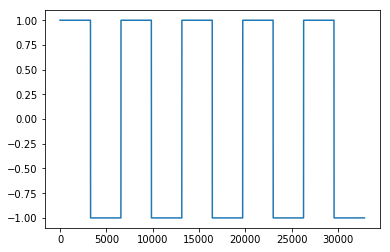

In [7]:
frames1 = np.load(root1+'32366_20170717_frames.npy')
x_rest = np.zeros((cnm1.C.shape[1]))

f = 0
mode = 1
for frame in frames1:
    x_rest[f:]=mode
    f+=frame
    mode=1-mode
 
x_rest = x_rest*2-1
plt.plot(x_rest)

/home/sebastian/Documents/CaImAn/caiman/base/traces.py:127: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(colors)


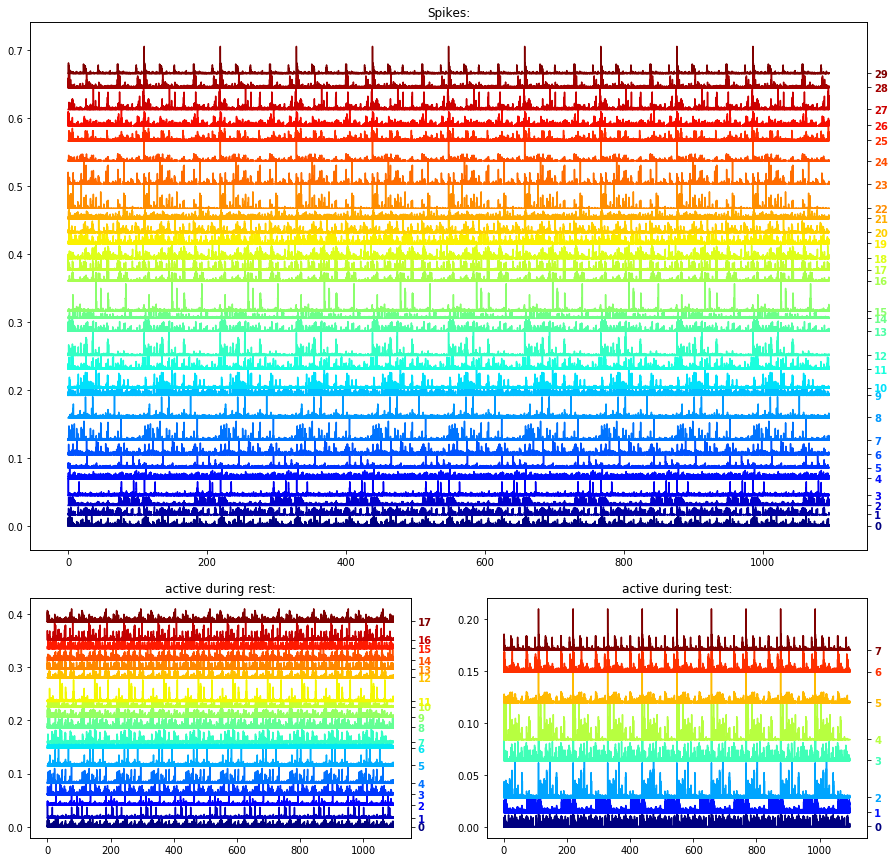

In [23]:
spikes = cnm1.S[:,:]
trains = np.zeros((spikes.shape[0]))

for i in range(trains.shape[0]):
    trains[i] = (spikes[i,:]*x_rest).mean()

trains = trains-trains.mean()

rest_active = np.where(trains>(trains.mean()+(.2*np.std(trains))))[0]
test_active = np.where(trains<(trains.mean()-(.2*np.std(trains))))[0]

plt.figure(1,figsize=(15, 15))

trc = trace(spikes[:,:].T)
plt.subplot2grid((3,2),(0,0),colspan=2,rowspan=2)
plt.title('Spikes:')
trc.plot()

plt.subplot2grid((3,2),(2,0))
plt.title('active during rest:')
trc = trace(spikes[rest_active,:].T)
trc.plot()


plt.subplot2grid((3,2),(2,1))
plt.title('active during test:')
trc = trace(spikes[test_active,:].T)
trc.plot()


### Statistical analysis:

Taking a look at the data, we can observe that the plots are dominated by few, very large spikes that seem to occur while the animals are transfered from their cage to the environment:

Text(0,0.5,'[n] cell')

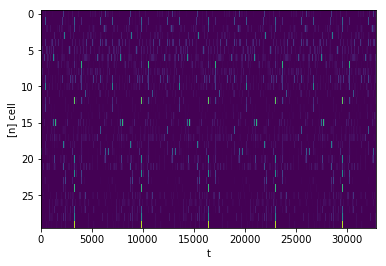

In [11]:
plt.imshow(spikes,aspect='auto')

plt.xlabel('t')
plt.ylabel('[n] cell')

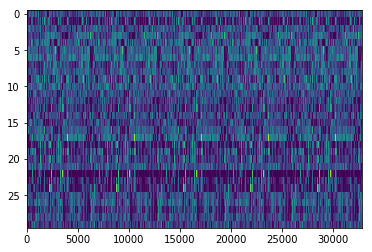

In [12]:
from scipy.ndimage.filters import gaussian_filter

spikes_norm = spikes.copy()
#spikes_norm =np.concatenate([spikes_norm,x_rest[np.newaxis,:]])


for j in range(spikes_norm.shape[0]):
    spikes_norm[j,:][spikes_norm[j,:]>spikes_norm[j,:].std()]=spikes_norm[j,:].std()
    spikes_norm[j,:]=gaussian_filter(spikes_norm[j,:],sigma=5)/spikes_norm[j,:].std()
    
plt.imshow(spikes_norm, aspect = 'auto')

explore spectrograms:

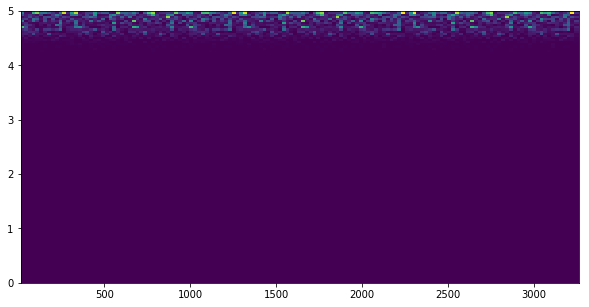

In [13]:
from  scipy.signal import spectrogram as spectrogram
plt.figure(2,figsize=(10, 5))

f, t, Sxx  = spectrogram(spikes_norm[0,:], 10)
#spec[2].shape
#plt.imshow(spec[2]],aspect='auto')

plt.pcolormesh(t, f, Sxx[::-1,])


Powers:

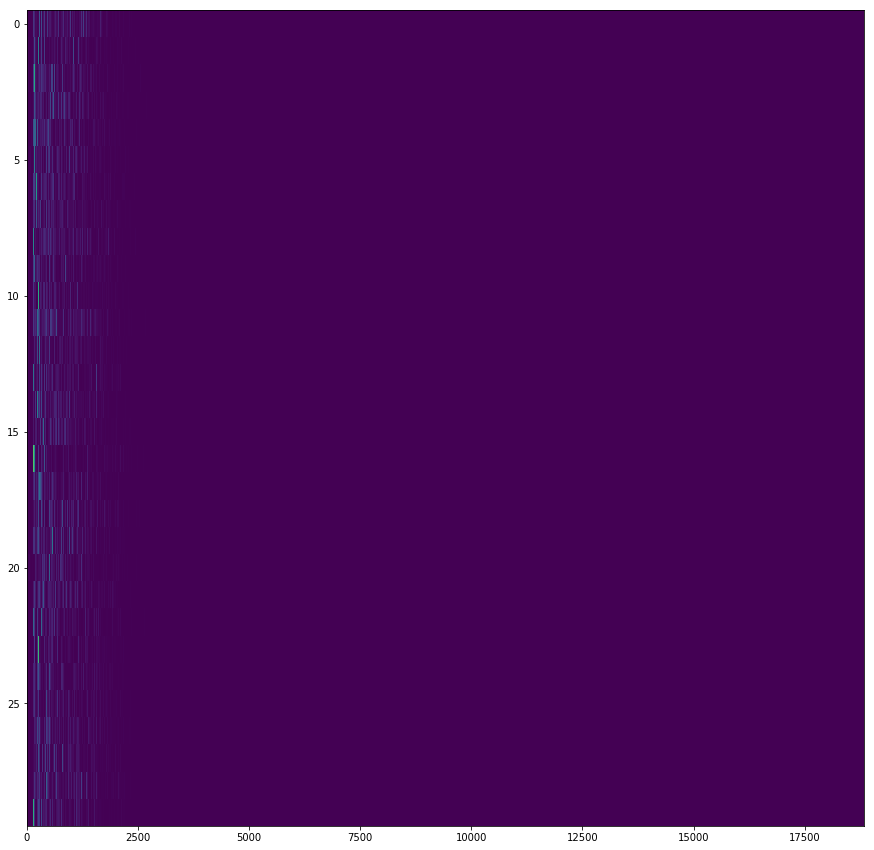

In [14]:
plt.figure(2,figsize=(15, 15))

powers = []
for p in range(spikes.shape[0]):
    powers.append([spectrogram(spikes_norm[p,:])[2].flatten()])
    powers[-1][0]-=powers[-1][0].mean()
    powers[-1][0]/=powers[-1][0].std()

powers=np.concatenate(powers)   
plt.imshow(powers,aspect='auto')

As a first exploratory attempt, we could just find correlations between the neurons:

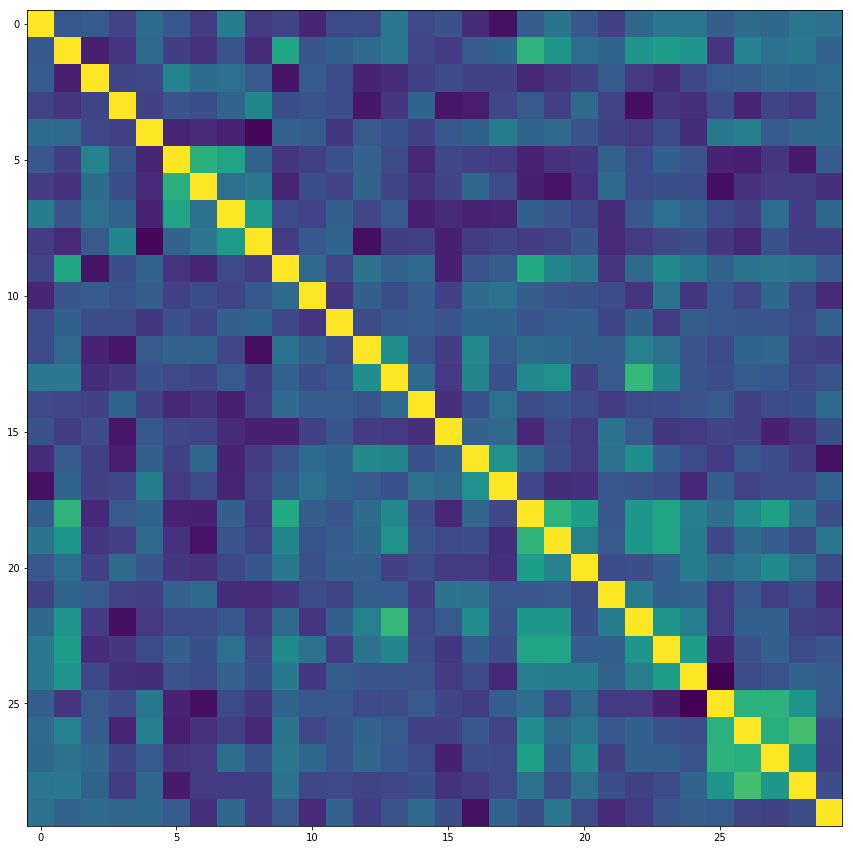

In [15]:
c_mat = np.corrcoef(spikes_norm)

plt.figure(2,figsize=(15, 15))

plt.imshow(c_mat)


Correlate, sort, show cells according to test/rest activity:



Text(0.5,0,'t')

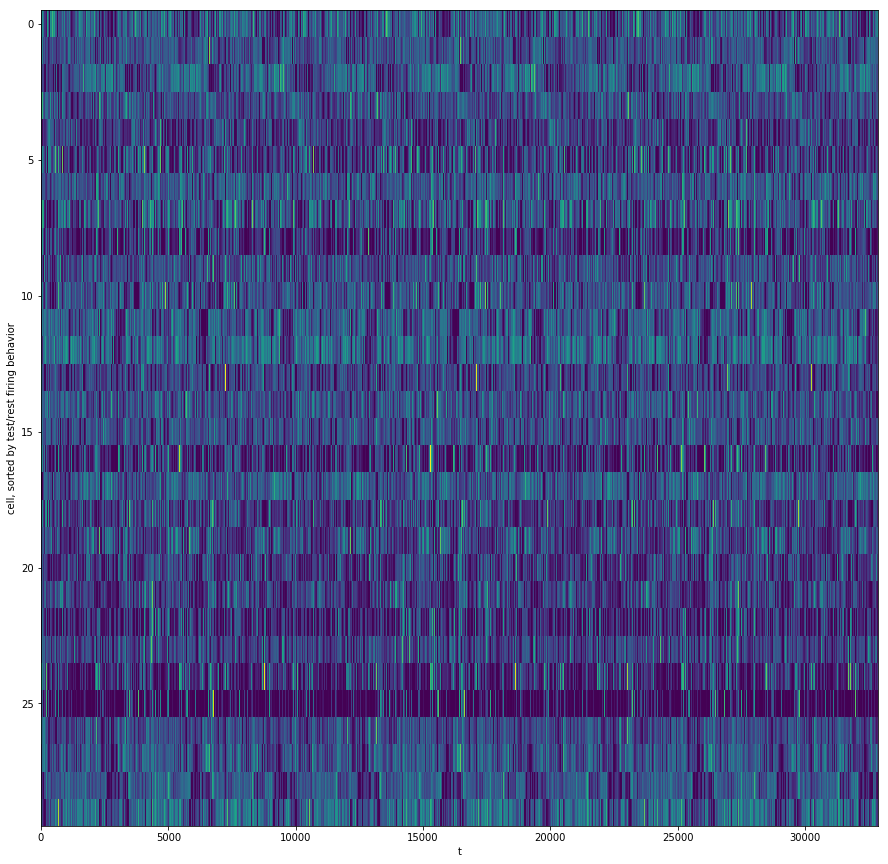

In [16]:
C = cnm1.C

for j in range(spikes_norm.shape[0]):
    C[j,:][C[j,:]>C[j,:].std()]=C[j,:].std()
    #C[j,:]=gaussian_filter(spikes_norm[j,:],sigma=1)/spikes_norm[j,:].std()
    

c_mat_active = np.corrcoef(np.concatenate([C,x_rest[np.newaxis,:]]))



plt.figure(2,figsize=(15, 15))

plt.imshow(spikes_norm[np.argsort(c_mat_active[-1,:-1]),:],aspect='auto')
plt.ylabel('cell, sorted by test/rest firing behavior')
plt.xlabel('t')

# len_kernel=20

spikes_smooth = spikes.copy()

x = np.arange(len_kernel)
for j in range(spikes_smooth.shape[0]):
    print(j)
    s=spikes[j,:]
    s1 = np.zeros(s.shape)
    for i in range(s.shape[0]-len_kernel):
        k = s[i:i+len_kernel]
        k1 = np.polyfit(x,k,deg=3)
        for e in range(len(k1)):
            s1[i:i+len_kernel]+= k1[e]*x**e
    spikes_smooth[j,:] = s1

In [17]:
from sklearn import decomposition

pca = decomposition.KernelPCA(kernel="cosine")
pca.fit(spikes_norm)
X = pca.transform(spikes_norm[:,:])
params = pca.get_params()


In [18]:
plt.plot(np.diff(s1)[0:500])

NameError: name 's1' is not defined

In [19]:
plt.plot(s[0:500])

NameError: name 's' is not defined

[115 137 138 145  99]
[116 211 123 198 137]
[202 177 141 140  84]
[166 113 122 126 117]


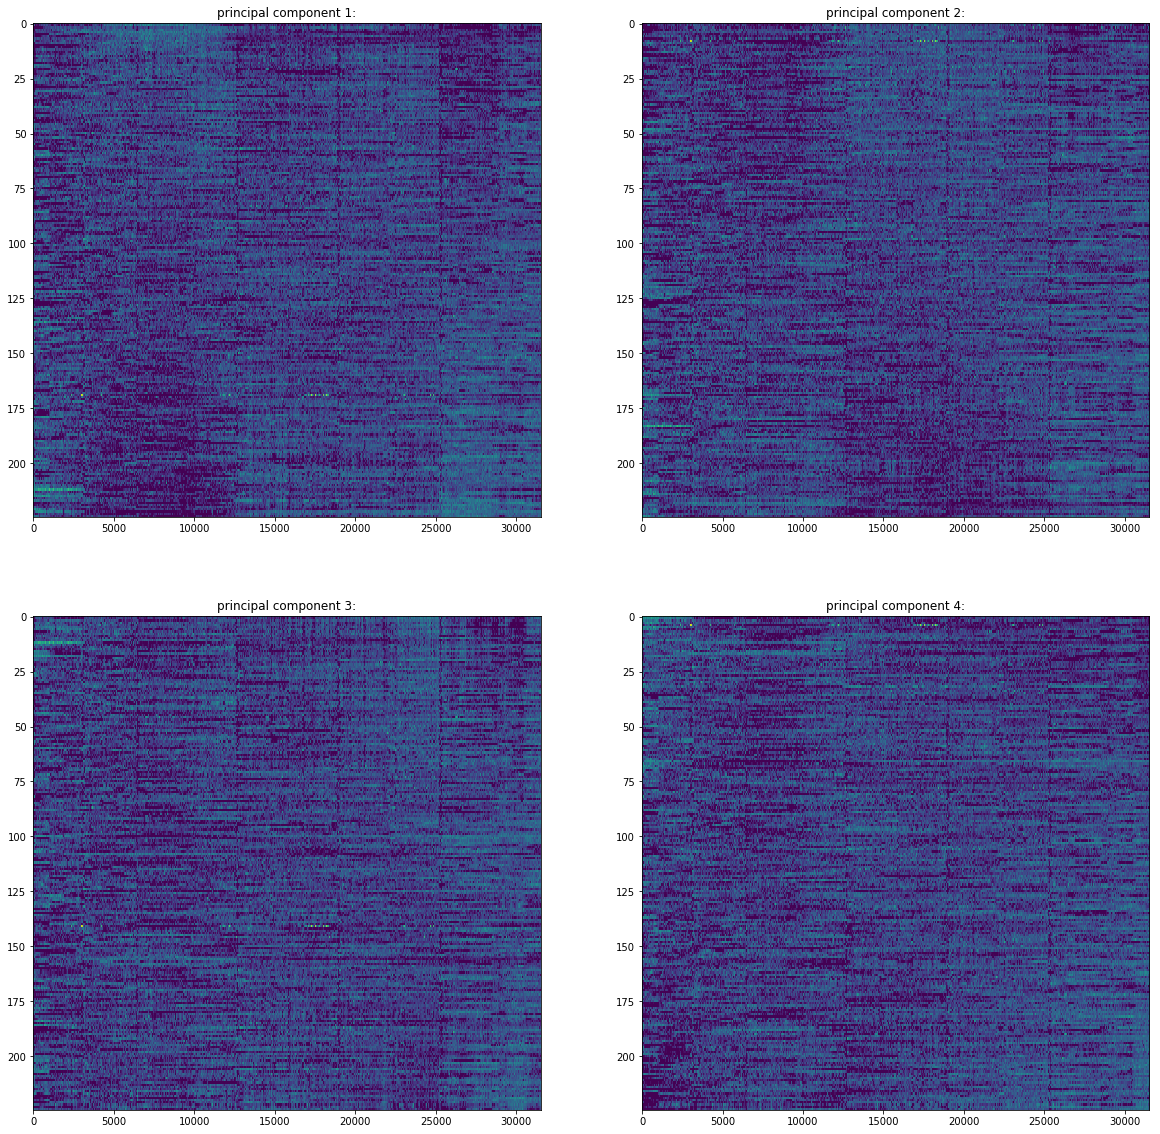

In [509]:
plt.figure(1,figsize=(20, 20))


for n in range(4):
    plcs = np.argsort(X[:,n])
    print(plcs[-5:])
    #plcs = np.argsort(c_mat[-1,:])
    plt.subplot(2,2,n+1)
    plt.title('principal component '+str(n+1)+':')

    
    plt.imshow(spikes_norm[plcs,:],aspect='auto')

# [115 106 145 138  99]
# [110  98  24 104 100]
# [112  87 122  95 170]
# [166 106 183 194 117]
# [ 40 111  60  56 178]
# [ 51 204 214 115  98]
# [168  11 106  98 139]
# [107  55 179 129  50]
# [142  91  85  74 141]


In [28]:
%matplotlib qt
inspect_correlation_pnr(cnm1.cn_filter,cnm1.pnr)


In [8]:
map_name1 = '32364_20170710_cropped_rig__d1_420_d2_600_d3_1_order_F_frames_31519_.mmap'
Yr1, dims1, T1 = cm.load_memmap(root1+map_name1)
Y1 = Yr1.T.reshape((T1,) + dims1, order='F')

gSig=3


In [9]:
np.shape(cnm1.A)
cnm1.compute_residuals(Yr1)


parallel dot product block size: 2000
Start product
Transposing
1999
3999
5999
7999
9999
11999
13999
15999
17999
19999
21999
23999
25999
27999
29999
31999
33999
35999
37999
39999
41999
43999
45999
47999
49999
51999
53999
55999
57999
59999
61999
63999
65999
67999
69999
71999
73999
75999
77999
79999
81999
83999
85999
87999
89999
91999
93999
95999
97999
99999
101999
103999
105999
107999
109999
111999
113999
115999
117999
119999
121999
123999
125999
127999
129999
131999
133999
135999
137999
139999
141999
143999
145999
147999
149999
151999
153999
155999
157999
159999
161999
163999
165999
167999
169999
171999
173999
175999
177999
179999
181999
183999
185999
187999
189999
191999
193999
195999
197999
199999
201999
203999
205999
207999
209999
211999
213999
215999
217999
219999
221999
223999
225999
227999
229999
231999
233999
235999
237999
239999
241999
243999
245999
247999
249999
251999


In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier


r_values_min = 0.5  # threshold on space consistency (if you lower more components will be accepted, potentially with worst quality)
decay_time = 0.1  #decay time of transients/indocator

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y1, cnm1.A, cnm1.C, cnm1.b, cnm1.f, cnm1.YrA, frate, 
                            decay_time, [gSig]*2, cnm1.dims, dview = dview, 
                            min_SNR=min_SNR, r_values_min = r_values_min, min_std_reject = 0.5, use_cnn = True)

print(' ***** ')
print((len(cnm1.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

EVALUATING IN PARALLEL... NOT RETURNING ERFCs


/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


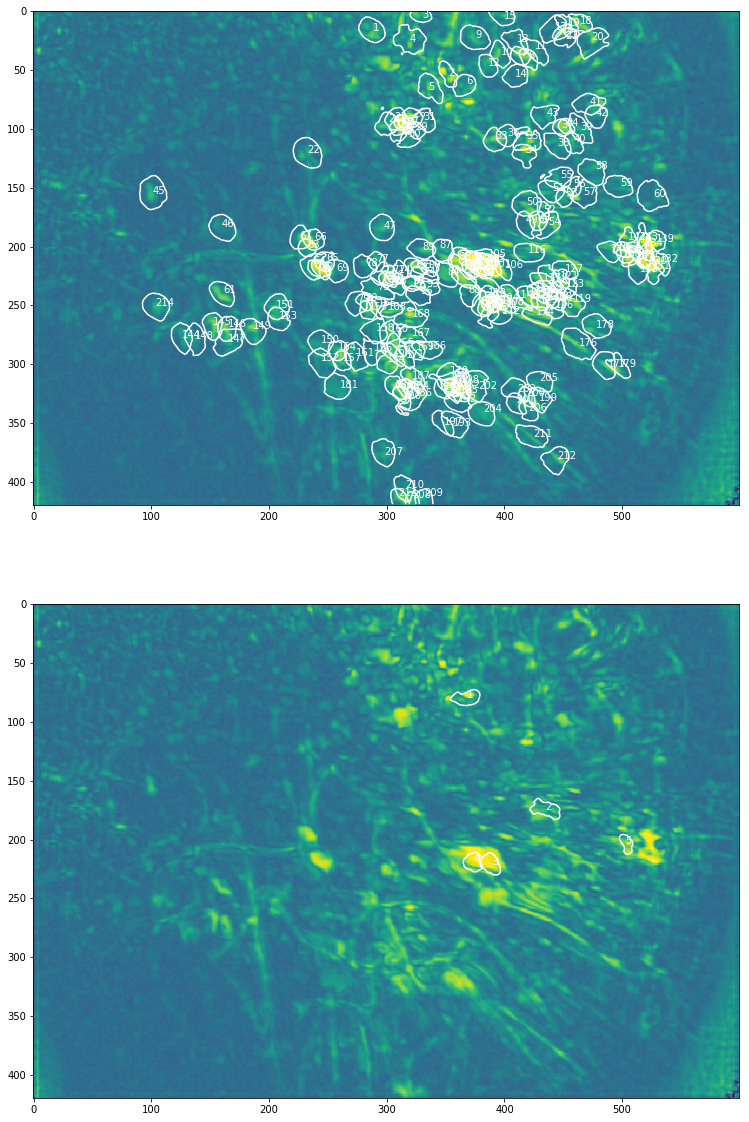

In [20]:
plt.figure(2,figsize=(20, 20))
plt.subplot(2,1,1)
crd = cm.utils.visualization.plot_contours(cnm1.A.tocsc()[:,idx_components], cnm1.cn_filter, thr=.8, vmax=0.95)


plt.subplot(2,1,2)
crd = cm.utils.visualization.plot_contours(cnm1.A.tocsc()[:,idx_components_bad], cnm1.cn_filter, thr=.8, vmax=0.95)


/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


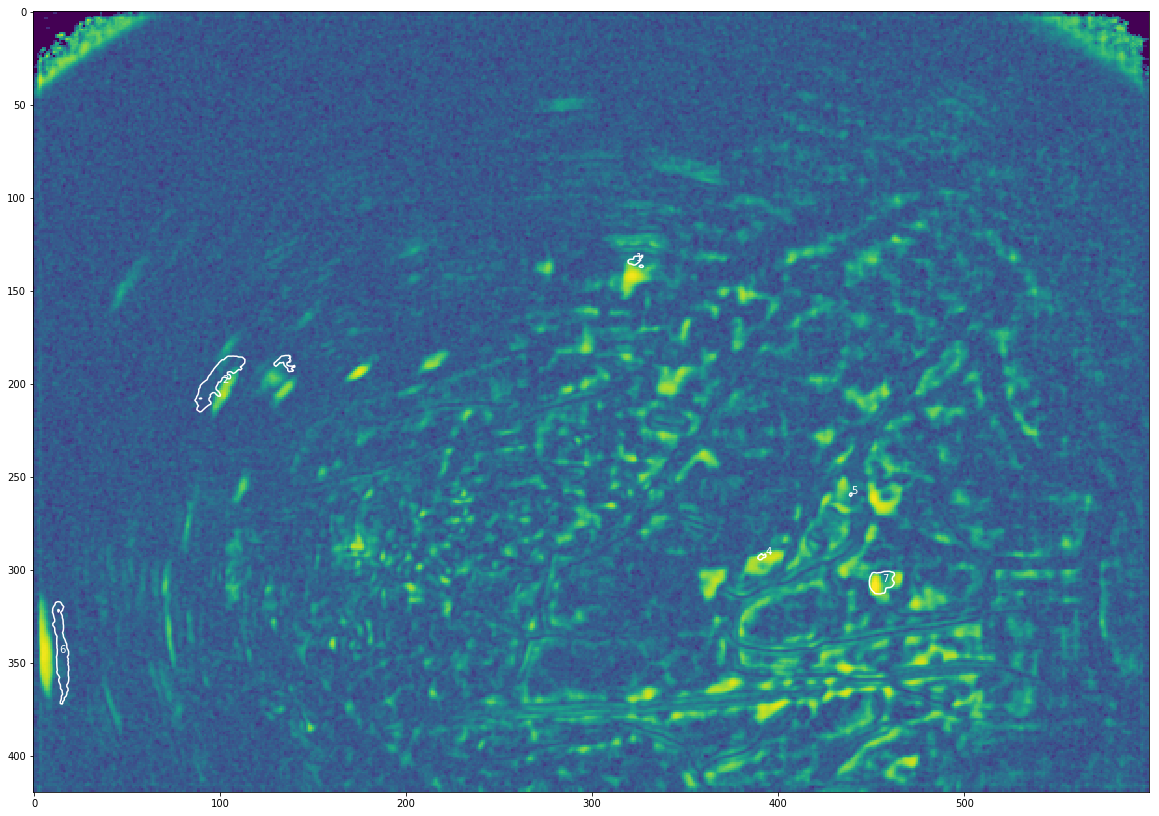

In [12]:
plt.figure(2,figsize=(20, 20))

crd = cm.utils.visualization.plot_contours(cnm1.A.tocsc()[:,:], cnm1.cn_filter, thr=.8, vmax=0.95)


### Load second CNMF object - let's have some fun! :D
plot contours of identified components against correlation image

In [ ]:
cnm2 = cnmf.CNMF(16)

path_cnmf_2 = "/home/sebastian/Desktop/dumped_files/20170711/cnmf_32364_20170711.pkl"

cnm2.load(path_cnmf_2)

plt.figure(figsize=(20, 15))

crd = cm.utils.visualization.plot_contours(cnm2.A, cnm2.cn_filter, thr=.8, vmax=0.95)


In [ ]:
matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance = register_ROIs(cnm1.A,cnm2.A,cnm1.dims,cnm1.cn_filter,cnm2.cn_filter)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(2,figsize=(20, 15))

plt.subplot(1,2,1)
crd3 = cm.utils.visualization.plot_contours(cnm1.A[:,matched_ROIs1], cnm1.cn_filter, thr=.9, vmax=0.95)
plt.subplot(1,2,2)
crd4 = cm.utils.visualization.plot_contours(cnm2.A[:,matched_ROIs2], cnm2.cn_filter, thr=.9, vmax=0.95)

In [ ]:
%matplotlib qt

spikes1 = cnm1.S[matched_ROIs1[::2],:]
spikes2 = cnm2.S[matched_ROIs2[::2],:]

trc1 = trace(spikes1.T)
trc2 = trace(spikes2.T)

plt.figure(3,figsize=(20, 20))


plt.subplot(1,2,1)
plt.title('spikes day 1:')
trc1.plot(cmap = plt.cm.tab20b)


plt.subplot(1,2,2)
plt.title('spikes day 2:')
trc2.plot(cmap = plt.cm.tab20b)


In [ ]:
cnm1.S[0].shape

### Stop cluster

In [ ]:
#%%
cm.stop_server(dview=dview)

In [480]:
map_name1 = '/home/sebastian/Desktop/32366_20170717_cropped_rig__d1_420_d2_600_d3_1_order_F_frames_32870_.mmap'
Yr1, dims1, T1 = cm.load_memmap(map_name1)
Y1 = Yr1.T.reshape((T1,) + dims1, order='F')


In [481]:
mov = cm.movie(Y1)
mov.play()